# [Advent of Code 2022](https://adventofcode.com/2022)
<div align="right"><i>Ben Emery<br>December 2022</i></div>


## The toolbox

Generalised pieces of code that either can be used in multiple questions or that simply makes understand the implementation easier.

In [1]:
from collections import defaultdict, Counter
from functools import cmp_to_key, reduce
from heapq import heappush, heappop
from math import ceil
from typing import Dict, Deque, List, Literal, NamedTuple, Tuple, Set, Callable, Union
from itertools import cycle
import operator
import re


def Input(day, parser=str.strip, whole_file=False):
    "Fetch the data input from disk."
    filename = f"../data/advent2022/input{day}.txt"
    with open(filename) as fin:
        if whole_file:
            return parser(fin)
        return mapt(parser, fin)


def mapt(fn, *args):
    "Do a map, and convert the results to a tuple"
    return tuple(map(fn, *args))


class Node:
    def __init__(self, name, data=None):
        self.name = name
        self.data = data
        self._children = []
        self.parent = None

    def __str__(self):
        return f"<Node name={self.name} parent={self.parent.name if self.parent else None} data={self.data}>"

    def add_child(self, node):
        self._children.append(node)
        node.parent = self

    @property
    def children(self):
        return self._children[:]

    @property
    def root(self):
        if self.parent:
            return self.parent.root
        return self


def visit_post_order(node: Node):
    for child in node.children:
        yield from visit_post_order(child)
    yield node
    

def a_star(start, h_func, moves, cost=lambda s1, s2: 1):
    """A* implementation.

    Finds the shortest sequence of states from to a goal (a state where
    the hueristic function - h_func - is zero). We use a heap
    as our priority queue, and processes those with the smallest
    overall cost first (the cost of the path + the distance to target).

    start:  the initial state to explore from
    h_func: hueristic function that gives a "distance" to to target state,
            when this is zero we're done.
    moves:  function that generates all possible states from the supplied state
            (these can go bakckwards, but will never be processed)
    cost:   the cost of moving from ones state to another

    return: list of states used to find the final state, wll raise an exception
            if none was found.

    """
    # The priority queue that we'll be reading from
    queue = []
    # We often care about the path taken, so persist the lowest costing path
    # to each state
    previous = {start: None}
    # Lookup of state costs, we initialize at zero for the starting state
    costs = {start: 0}

    # Initialize our queue, this is ordered by path cost (f(n) = g(n) + h(n))
    add_to_queue = lambda state: heappush(queue, (costs[state] + h_func(state), state))

    # Recursively walk backwards to build the full path
    get_path = (
        lambda state: [] if state is None else get_path(previous[state]) + [state]
    )

    # Set the intial position and go!
    add_to_queue(start)

    while queue:
        _, state = heappop(queue)
        if h_func(state) == 0:
            # We're done!
            return get_path(state)

        for new_state in moves(state):
            new_cost = costs[state] + cost(state, new_state)

            if new_state not in costs or new_cost < costs[new_state]:
                # We've found a new state or a better path
                costs[new_state] = new_cost
                previous[new_state] = state
                # We've modified our costs in some way, we need
                # to explore from this state so add to the heap
                add_to_queue(new_state)

    # No solution was found
    raise Exception("No solution for A* was discovered.")

    
NEIGHBOUR4_DELTAS = (
              ( 0, -1),
    (-1,  0),           (1,  0),
              ( 0,  1),
)


def neighbours4(x, y):
    return tuple((x + dx, y + dy) for dx, dy in NEIGHBOUR4_DELTAS)

## [Day 1](https://adventofcode.com/2022/day/1)

Nothing too difficult for day 1, other than remembering how jupyter notebooks / python works...

### Day 1.1

In [2]:
data = Input(1, lambda s: int(s) if s.strip() else None)

def total_calories(data):
    elves = [0]
    for food in data:
        if food is None:
            elves.append(0)
            continue
        elves[-1] += food
    return elves

elves = total_calories(data)

max(elves)

70296

In [3]:
assert _ == 70296, "Day 1.1"

### Day 1.2

In [4]:
elves.sort()
sum(elves[-3:])

205381

In [5]:
assert _ == 205381, "Day 1.2"

## [Day 2](https://adventofcode.com/2022/day/2)

Again we're being eased in quite gently, unless you get dicts the wrong way around of course..

### Day 2.1

In [6]:
data = Input(2, lambda s: s.strip().split(" "))

ROCK = "R"
PAPER = "P"
SCISSORS = "S"

SCORES = {ROCK: 1, PAPER: 2, SCISSORS: 3}
WINNING = {SCISSORS: ROCK, ROCK: PAPER, PAPER: SCISSORS}
LOSING = dict((v, k) for k, v in WINNING.items())


def map_hands(player_1, player_2):
    map_1 = {"A": ROCK, "B": PAPER, "C": SCISSORS}
    map_2 = {"X": ROCK, "Y": PAPER, "Z": SCISSORS}
    return map_1[player_1], map_2[player_2]


def score_game(p1, p2):
    score = 3 if p1 == p2 else 0
    if p2 == WINNING[p1]:
        score = 6
    return score + SCORES[p2]


def score_all_games(data, hand_mapper):
    hands = (map_hands(*d) for d in data)
    return sum(score_game(*h) for h in hands)


score_all_games(data, map_hands)

11449

In [7]:
assert _ == 11449, "Day 2.1"

### Day 2.2

In [8]:
def map_hands(player_1, player_2):
    map_1 = {"A": "R", "B": "P", "C": "S"}
    p1 = map_1[player_1]

    if player_2 == "X":
        p2 = LOSING[p1]
    elif player_2 == "Y":
        p2 = p1
    elif player_2 == "Z":
        p2 = WINNING[p1]

    return p1, p2


score_all_games(data, map_hands)

13187

In [9]:
assert _ == 13187, "Day 2.2"

## [Day 3](https://adventofcode.com/2022/day/3)

First time we need a set, membership tests are O(1) so they make sense to use here. Python makes it quite easy to extend behaviour for part 2, but I find I'm missing a more functional approach..

### Day 3.1

In [10]:
data = Input(3)


def split_halves(contents):
    mid = int(len(contents) / 2)
    return contents[:mid], contents[mid:]


def find_common(*chunks):
    common = set(chunks[0])
    for chunk in chunks[1:]:
        common &= set(chunk)
    return tuple(common)


def score(s):
    ordinal = ord(s)
    if ordinal > 96:
        score = ordinal - ord("a") + 1
    else:
        score = ordinal - ord("A") + 26 + 1
    return score


def solve(all_data, grouper):
    total = 0
    for chunks in grouper(all_data):
        common = find_common(*chunks)
        total += score(common[0])
    return total


solve(data, lambda lines: map(split_halves, lines))

7967

In [11]:
assert _ == 7967, "Day 3.1"

### Day 3.2

In [12]:
def group_threes(lines):
    for idx in range(0, len(lines) - 1, 3):
        yield lines[idx : idx + 3]


solve(data, lambda lines: group_threes(lines))

2716

In [13]:
assert _ == 2716, "Day 3.2"

## [Day 4](https://adventofcode.com/2022/day/4)


I quite enjoyed this one, refactoring the check for detecting supersets meant that I could solve the second part with little effort, which is useually the besy way to go!

### Day 4.1

In [14]:
def parse_line(line):
    m = re.match("(\d+)-(\d+),(\d+)-(\d+)", line)
    a, b, c, d = m.groups()
    return ((int(a), int(b)), (int(c), int(d)))


data = Input(4, parse_line)


def count_supersets(lines, is_within):
    return sum(is_within(p1, p2) or is_within(p2, p1) for p1, p2 in lines)


def contains_entirely(p1, p2):
    return p1[0] >= p2[0] and p1[1] <= p2[1]


count_supersets(data, contains_entirely)

453

In [15]:
assert _ == 453, "Day 4.1"

### Day 4.2

In [16]:
def contains_partially(p1, p2):
    return (p1[0] >= p2[0] and p1[0] <= p2[1]) or (p1[1] <= p2[1] and p1[1] >= p2[0])


count_supersets(data, contains_partially)

919

In [17]:
assert _ == 919, "Day 4.2"

## [Day 5](https://adventofcode.com/2022/day/5)

Today's felt like one of those puzzles where the hardest part was parsing the input! Reminding myself how python's regex matches works was fun though, and it's also a good lesson about something I've struggled with in the past: pragmatism. Parsing the data doesn't need to be dynamic, we can apply what we know from the inputs to help us out (that there are 9 stacks for example). In fancier language I'd say that we can use a heuristic to simplify things, but who needs that first thing in the morning?

### Day 5.1

In [18]:
def parse_data(lines):
    stacks = [[], [], [], [], [], [], [], [], []]
    instructions = []

    def add_to_stack(line):
        for match in re.finditer("[A-Z]", line):
            stack = match.start() // 4
            stacks[stack].insert(0, match.group())

    def add_instruction(line):
        move, pos_from, pos_to = mapt(int, re.findall("\d+", line))
        instructions.append((move, pos_from - 1, pos_to - 1))

    stacks_complete = False
    for line in lines:
        if not line.strip():
            stacks_complete = True
            continue

        if not stacks_complete:
            add_to_stack(line)
        else:
            add_instruction(line)

    return stacks, instructions


data = Input(5, parse_data, whole_file=True)


def single_mover(stacks, instruction):
    move, pos_from, pos_to = instruction
    for _ in range(move):
        val = stacks[pos_from].pop()
        stacks[pos_to].append(val)


def follow_instructions(stacks, instructions, mover):
    new_stacks = [s[:] for s in stacks]

    for instruction in instructions:
        mover(new_stacks, instruction)
    return new_stacks


def top_crates(stacks):
    return "".join(s[-1] for s in stacks)


stacks = follow_instructions(*data, single_mover)
top_crates(stacks)

'LBLVVTVLP'

In [19]:
assert _ == "LBLVVTVLP", "Day 5.1"

### Day 5.2

In [20]:
def bulk_mover(stacks, instruction):
    move, pos_from, pos_to = instruction
    stacks[pos_to].extend(stacks[pos_from][-move:])
    stacks[pos_from] = stacks[pos_from][:-move]


stacks = follow_instructions(*data, bulk_mover)
top_crates(stacks)

'TPFFBDRJD'

In [21]:
assert _ == "TPFFBDRJD", "Day 5.2"

## [Day 6](https://adventofcode.com/2022/day/6)

Still nothing supuer difficult about this problem, using sets to track uniqueness may be a bit much, but given the size of the data it still returns instantly so why not!

### Day 6.1

In [22]:
data = Input(6)[0]


def iter_chunks(data, n):
    for i in range(0, len(data) - n):
        yield i, data[i : i + n]


def count_chars_to_packet(data, length=4):
    for idx, chunk in iter_chunks(data, length):
        if len(set(chunk)) == length:
            break
    chars_processed = idx + length
    return chars_processed


count_chars_to_packet(data, 4)

1598

In [23]:
assert _ == 1598, "Day 6.1"

### Day 6.2

In [24]:
count_chars_to_packet(data, 14)

2414

In [25]:
assert _ == 2414, "Day 6.2"

## [Day 7](https://adventofcode.com/2022/day/7)

First tree based problem! Had a really annoying bug with files / directories that had the same name, so ended up overwriting parts of the tree. Blugh. Significant part of the work went into building the tree, I suppose I didn't really need to do that, just build the sizes as you go and don't duplicate contributions to the same parent...

But that's waaaay less fun!


### Day 7.1

In [26]:
data = Input(7)


def _group_commands(lines):
    """Convert lines into a command, arguments, and outputs"""
    _, current_command, *args = lines[0].split(" ")
    outputs = []

    for line in lines[1:]:
        if line.startswith("$"):
            yield (current_command, args), outputs
            _, current_command, *args = line.split(" ")
            outputs = []
        else:
            outputs.append(tuple(line.split(" ")))
    yield (current_command, args), outputs


def build_tree(output_lines):
    """Take input data and build a directory tree"""
    node_lookup = {}

    def dir_key(parent, dir_name):
        if not parent:
            return dir_name
        return dir_key(parent.parent, parent.name) + "/" + dir_name

    def cd(args, _, current_node, node_lookup):
        new_dir = args[0]
        if new_dir == "..":
            return current_node.parent

        key = dir_key(current_node, new_dir)
        if key not in node_lookup:
            node = Node(new_dir)
            if current_node:
                current_node.add_child(node)
            node_lookup[key] = node

        return node_lookup[key]

    def ls(args, cmd_outputs, current_node, node_lookup):
        for chunks in cmd_outputs:
            if chunks[0] == "dir":
                dirname = chunks[1]
                key = dir_key(current_directory, dirname)

                if key not in node_lookup:
                    node_lookup[key] = Node(dirname)
                    current_node.add_child(node_lookup[key])
            else:
                size, filename = chunks
                current_node.add_child(Node(filename, int(size)))
        return current_node

    # execute all the commands
    current_directory = None
    for (cmd, args), outputs in _group_commands(output_lines):
        if cmd == "cd":
            command = cd
        elif cmd == "ls":
            command = ls
        else:
            raise Error(f"Unknown command {cmd}")
        current_directory = command(args, outputs, current_directory, node_lookup)
    return current_directory.root


def get_sub_directory_sizes(tree):
    sizes = defaultdict(int)

    for node in visit_post_order(tree):
        if not node.parent:
            # is root, don't care
            continue

        if node.data is not None:
            # contribute directly to the parent directory's size
            sizes[node.parent] += node.data
        else:
            # we'll have visited all the children of sub-directories before,
            # so use the cached result
            sizes[node.parent] += sizes[node]

    return sizes


def sum_directories_below_limit(data):
    tree = build_tree(data)
    sizes = get_sub_directory_sizes(tree)

    total = 0
    for dirname, size in sizes.items():
        if size <= 100000:
            total += size
    return total


sum_directories_below_limit(data)

1297683

In [27]:
assert _ == 1297683, "Day 7.1"

### Day 7.2

Now all the hard work of the first section is done, the second was pretty simple.

In [28]:
def find_smallest_directory_to_delete(data):
    tree = build_tree(data)
    directory_sizes = get_sub_directory_sizes(tree)

    total_size = directory_sizes[tree]

    remaining_space = 70000000 - total_size
    required_space = 30000000

    # start with the root node
    smallest = tree
    for node, size in directory_sizes.items():
        if node.data is not None:
            # is a file, skip
            continue

        if remaining_space + size > required_space:
            if size < directory_sizes[smallest]:
                smallest = node

    return directory_sizes[smallest]


find_smallest_directory_to_delete(data)

5756764

In [29]:
assert _ == 5756764, "Day 7.2"

## [Day 8: Treetop Tree House](https://adventofcode.com/2022/day/8)

I guess this is technically another _tree_ based problem? :) Nothing particularly exciting about this solution, I got something to work and then stopped thinking about it..

### Day 8.1

In [30]:
data = Input(8, lambda s: mapt(int, s.strip()))


def count_visible_tress(lines):
    width = len(lines[0])
    height = len(lines)

    seen_trees = set()

    # first pass, left to right and right to left
    for y in range(1, height - 1):
        left_min_tree = lines[y][0]
        right_min_tree = lines[y][width - 1]

        for x in range(1, width - 1):
            if lines[y][x] > left_min_tree:
                seen_trees.add((x, y))
                left_min_tree = lines[y][x]
            if lines[y][width - x - 1] > right_min_tree:
                seen_trees.add((width - x - 1, y))
                right_min_tree = lines[y][width - x - 1]

    # second pass, top to bottom and bottom to top
    for x in range(1, width - 1):
        top_min_tree = lines[0][x]
        bottom_min_tree = lines[height - 1][x]

        for y in range(1, height - 1):
            if lines[y][x] > top_min_tree:
                seen_trees.add((x, y))
                top_min_tree = lines[y][x]
            if lines[height - y - 1][x] > bottom_min_tree:
                seen_trees.add((x, height - y - 1))
                bottom_min_tree = lines[height - y - 1][x]

    perimiter = 2 * width + 2 * height - 4
    return perimiter + len(seen_trees)


count_visible_tress(data)

1719

In [31]:
assert _ == 1719

### Day 8.2

In [32]:
def get_scenic_score(lines):
    width = len(lines[0])
    height = len(lines)

    best_score = 0
    for y in range(height):
        for x in range(width):
            tree = lines[y][x]

            see_left = 0
            for xl in range(x - 1, -1, -1):
                if lines[y][xl] >= tree:
                    see_left += 1
                    break
                see_left += 1

            see_right = 0
            for xr in range(x + 1, width):
                if lines[y][xr] >= tree:
                    see_right += 1
                    break
                see_right += 1

            see_top = 0
            for yt in range(y - 1, -1, -1):
                if lines[yt][x] >= tree:
                    see_top += 1
                    break
                see_top += 1

            see_bottom = 0
            for yb in range(y + 1, height):
                if lines[yb][x] >= tree:
                    see_bottom += 1
                    break
                see_bottom += 1

            scenic_score = see_left * see_top * see_right * see_bottom
            best_score = max(best_score, scenic_score)

    return best_score


get_scenic_score(data)

590824

In [33]:
assert _ == 590824, "Day 8.2"

## [Day 9: Rope Bridge](https://adventofcode.com/2022/day/9)

This one killed me! I could not for the life of me conceptualise what the movements were doing. Definitely glad this one is over.

### Day 9.1

In [34]:
def parse_line(line):
    chunks = line.split(" ")
    return chunks[0], int(chunks[1])


def is_adjacent(p1, p2):
    return max(abs(a - b) for a, b in zip(p1, p2)) <= 1


def move_to_point(from_point, to_point):
    fx, fy = from_point
    tx, ty = to_point

    # if not on the same plane, then step in that direction
    move_point = lambda p1, p2: p1 if p1 == p2 else p1 + 1 if p1 < p2 else p1 - 1

    x = move_point(fx, tx)
    y = move_point(fy, ty)

    return x, y


def follow_motions(motions, rope_length=2):
    ropes = [(0, 0) for _ in range(rope_length)]

    deltas = {"R": (1, 0), "D": (0, -1), "L": (-1, 0), "U": (0, 1)}

    add_points = lambda p1, p2: tuple(a + b for a, b in zip(p1, p2))

    def step(direction, ropes):
        head_pos = ropes[0]
        dx, dy = deltas[direction]
        x, y = head_pos
        new_head_pos = (x + dx, y + dy)

        new_positions = [new_head_pos]
        for tail in ropes[1:]:
            target = new_positions[-1]
            if is_adjacent(tail, target):
                # within distance, no need to move
                new_positions.append(tail)
                continue

            new_tail_pos = move_to_point(tail, target)
            new_positions.append(new_tail_pos)
        return new_positions

    for direction, amount in motions:
        for _ in range(amount):
            ropes = step(direction, ropes)
            yield ropes


def count_unique_locations(motions, rope_length=2):
    visited = set()
    for rope in follow_motions(motions, rope_length):
        *_, tail_pos = rope
        visited.add(tail_pos)
    return len(visited)


data = Input(9, parse_line)
count_unique_locations(data)

6357

In [35]:
assert _ == 6357, "Day 9.1"

### Day 9.2

In [36]:
count_unique_locations(data, rope_length=10)

2627

In [37]:
assert _ == 2627, "Day 9.2"

## [Day 10: Cathode-Ray Tube](https://adventofcode.com/2022/day/10)

This was quite fun, making use of python's generators to suspend execution meant that I could simulate the clock cycles quite nicely.

### Day 10.1

In [38]:
def parse_line(line):
    cmd, *args = line.strip().split(' ')
    if cmd == "addx":
        return cmd, int(args[0])
    return cmd, args

instructions = Input(10, parse_line)

def perform_instructions(instructions):
    # init the "reigister"
    x = 1
    for ins, *args in instructions:
        if ins == "noop":
            yield x
        elif ins == "addx":
            value = args[0]
            yield x
            x += value
            yield x

            
def sum_signal_strength(instructions):
    total = 0
    for executed_instruction_idx, x in enumerate(perform_instructions(instructions), 1):
        current_cycle = executed_instruction_idx + 1
        if (current_cycle - 20) % 40 == 0:
            total += current_cycle * x
    return total

            
sum_signal_strength(instructions)

13760

In [39]:
assert _ == 13760, "Day 10.1"

### Day 10.2

It's always quite fun when there's some ascii art invovled :D 

In [40]:
def draw_sprite(instructions):
    # not in the puzzle, but easier to read
    OFF_CHAR = " "
    ON_CHAR = "#"
    WIDTH = 40
    HEIGHT = 6
    rows = [[OFF_CHAR] * WIDTH for _ in range(HEIGHT)]

    for executed_instruction_idx, x in enumerate(perform_instructions(instructions), 1):
        row_being_drawn = executed_instruction_idx // WIDTH
        pixel_being_drawn = executed_instruction_idx % WIDTH

        if x >= pixel_being_drawn - 1 and x <= pixel_being_drawn + 1:
            rows[row_being_drawn][pixel_being_drawn] = ON_CHAR

    print("\n".join("".join(r) for r in rows))


draw_sprite(instructions)

 ##  #### #  # ####  ##  ###  #### #### 
#  # #    # #     # #  # #  # #    #    
#  # ###  ##     #  #    #  # ###  ###  
###  #    # #   #   #    ###  #    #    
# #  #    # #  #    #  # #    #    #    
#  # #    #  # ####  ##  #    #### #    


## [Day 11: Monkey in the Middle](https://adventofcode.com/2022/day/11)

Well this one was interesting, I've been bitten by the Chinese Remainder Theorem before, so spent a bit of time in the write up for part 2 below.

There's some abose of python's `operator` library below which I'm not super happy about, but it'll do.

### Day 11.1

In [41]:
def parse_input(lines):
    monkeys = []
    ops = {"+": operator.add, "*": operator.mul}

    def get_new_func(operation, operation_value):
        if operation_value == "old":
            return lambda val: ops[operation](val, val)
        return lambda val: ops[operation](val, int(operation_value))

    # we're given a file input to parse, read all the lines and clear new line chars
    lines = [l.strip() for l in lines]
    for idx in range(0, len(lines), 7):
        starting_items = [int(d) for d in re.findall("\d+", lines[idx + 1])]

        *_, operation, operation_new = lines[idx + 2].split(" ")

        test_modulo = int(lines[idx + 3].split(" ")[-1])
        test_true_result = int(lines[idx + 4].split(" ")[-1])
        test_false_result = int(lines[idx + 5].split(" ")[-1])

        monkeys.append(
            {
                "starting_items": starting_items,
                "get_new_worry": get_new_func(operation, operation_new),
                "test_modulo": test_modulo,
                "true_monkey": test_true_result,
                "false_monkey": test_false_result,
            }
        )

    return monkeys


data = Input(11, parse_input, whole_file=True)


def fast_monkey_business(monkeys, round_count=20, apply_reduction=True):
    # clone the starting items as we mutate them in place
    starting_items = dict(
        (idx, m["starting_items"][:]) for idx, m in enumerate(monkeys)
    )
    counter = dict((idx, 0) for idx in range(len(monkeys)))

    # we know that the modulos are coprime, so we can safely reduce large modulos by their
    # lowest multiple, see text below for explanation
    module_multiple = reduce(operator.mul, [m["test_modulo"] for m in monkeys])
    # crt == chinese remainder theorem
    apply_crt = lambda worry: worry % module_multiple

    reduce_worry = apply_crt

    if apply_reduction:
        reduce_worry = lambda worry: worry // 3

    for _ in range(round_count):
        for idx, monkey in enumerate(monkeys):
            while starting_items[idx]:
                item = starting_items[idx].pop(0)
                new_worry = monkey["get_new_worry"](item)
                new_level = reduce_worry(new_worry)

                if new_level % monkey["test_modulo"] == 0:
                    new_target = monkey["true_monkey"]
                else:
                    new_target = monkey["false_monkey"]
                starting_items[new_target].append(new_level)

                counter[idx] += 1

    return counter


def find_busiest_monkeys(*args, **kwargs):
    counter = fast_monkey_business(*args, **kwargs)
    a, b = sorted(counter.values())[-2:]
    return a * b


find_busiest_monkeys(data)

50616

In [42]:
assert _ == 50616, "Day 11.1"

### Day 11.2

We're warned that the brute force of the first part won't work for the second, as the step of divising by 3 is going away, and need to do something else.

Looking at the Test divisors from the input (mine are 5, 2, 13, 19, 11, 3, 7, 17), we can see that they are all prime, and thus have a greatest common divisor (GCD) of 1.

This means we can use the [Chinese Remainder Theorm](https://en.wikipedia.org/wiki/Chinese_remainder_theorem) to keep the "worry level" low. 

...but what does that _mean_.

We know we need to perform several rounds of `X mod(y)`, but what happens if `X` is much, much larger than `y`? The operation becomes slow, it'd be nice if we could use a larger number to mod it against. As were dealing with modulo arithmitic, it's worth reminding oursleves (as I had to..) that `X mod(y)` is the same as `X mod(y * C) mod(y)` for _any_ C. i.e.

```
1345 mod(19) = 15
1345 mod(19 * 2) mod(19) = 15 mod (19) = 15
1345 mod(19 * 3) mod(19) = 34 mod (19) = 15
```

As we know that all our modulos do _not share a common factor_ then their multiple will be a large number that is the lowest common multiple of all of them. So taking the first three examples I've shown above:

```
1345 mod(2) = 1
1345 mod(2 * 3 * 19) mod(2) = 91 mod(2) = 1

1345 mod(3) = 1
1345 mod(2 * 3 * 19) mod(4) = 91 mod(3) = 1

1345 mod(19) = 15
1345 mod(2 * 3 * 19) mod(19) = 91 mod(15) = 15

```

Hopefully that's a useful example of how the CRT works.

In [43]:
# I just refactored the code in part one..
find_busiest_monkeys(data, 10_000, False)

11309046332

In [44]:
assert _ == 11309046332, "Day 11.2"

## [Day 12: Hill Climbing Algorithm](https://adventofcode.com/2022/day/12)

First breadth first search! I've just cracked out an A* implementation I wrote a few years ago, but it's always such a joy to use. A* is such an elegant algorithm, I love it!

For some extra fun, someone made a simulation of their solution in [minecraft](https://www.reddit.com/r/adventofcode/comments/zjsgaa/2022_day_12_part_2_in_minecraft/).

### Day 12.1

In [45]:
def find_all_cells(cell, grid):
    for y, row in enumerate(grid):
        try:
            x = row.index(cell)
            yield x, y
        except ValueError:
            pass


def find_cell(cell, grid):
    return next(find_all_cells(cell, grid))


def find_destination_position(grid):
    END_CELL = "E"
    return find_cell(END_CELL, grid)


def find_start_position(grid):
    START_CELL = "S"
    return find_cell(START_CELL, grid)


def fewest_steps(grid, start, destination):
    def normalise_grid(grid):
        rows = []
        for row in grid:
            new_row = []
            for cell in row:
                if cell == "S":
                    new_row.append(0)
                    continue
                if cell == "E":
                    new_row.append(ord("z") - ord("a"))
                    continue
                new_row.append(ord(cell) - ord("a"))
            rows.append(new_row)
        return rows

    grid_as_numbers = normalise_grid(grid)

    Y_LIMIT = len(grid) - 1
    X_LIMIT = len(grid[0]) - 1

    def h_func(state):
        """Cost function is manhatten distance from destination."""
        return abs(state[0] - destination[0]) + abs(state[1] - destination[1])

    def moves(state):
        x, y = state
        current_cell = grid_as_numbers[y][x]

        for (
            nx,
            ny,
        ) in neighbours4(x, y):
            if nx < 0 or ny < 0 or nx > X_LIMIT or ny > Y_LIMIT:
                continue

            new_cell = grid_as_numbers[ny][nx]
            if new_cell - current_cell > 1:
                # can't climb UP more than one, but can go down
                continue

            yield nx, ny

    shortest_path = a_star(start, h_func, moves)
    return len(shortest_path) - 1


def fewest_steps_fixed_start(grid):
    start = find_start_position(grid)
    destination = find_destination_position(grid)
    return fewest_steps(grid, start, destination)


data = Input(12)
fewest_steps_fixed_start(data)

423

In [46]:
assert _ == 423, "Day 12.1"

### Day 12.2

In [47]:
def fewest_steps_lowest_start(grid):
    destination = find_destination_position(grid)
    start_positions = find_all_cells("a", grid)
    return min(fewest_steps(grid, start, destination) for start in start_positions)


fewest_steps_lowest_start(data)

416

In [48]:
assert _ == 416, "Day 12.2"

## [Day 13: Distress Signal](https://adventofcode.com/2022/day/13)

Parsing the input on this tooko me a while to settle on a procedure. I went for recursion as each sub-list can be modelled as a sub-set of the larger problem, the problem became keeping the pointer for where we were in the input accurate!

...I then realised I could have just used eval.

### Day 13.1

In [49]:
def parse_input(lines):
    all_lines = list(lines)

    packets = []

    def parse_packet(line):
        entire_stack = []

        def go(idx, stack):
            while idx < len(line):
                char = line[idx]

                if char == "[":
                    # solve the sub problem
                    child_stack = []
                    stack.append(child_stack)
                    idx = go(idx + 1, child_stack)
                elif char == "]":
                    # probem solved, return where we got to
                    return idx
                elif char == ",":
                    # noop
                    pass
                else:
                    # have a number, read all and jump ahead
                    match = re.match(r"^(\d+)", line[idx:])
                    val = int(match.groups()[0])
                    stack.append(val)

                    # jump to the end of the match
                    idx = idx + match.end() - 1

                # advance to next char
                idx += 1
            return idx

        go(0, entire_stack)

        return entire_stack

    for idx in range(0, len(all_lines), 3):
        left_line = all_lines[idx]
        left_packet = parse_packet(left_line)

        right_line = all_lines[idx + 1]
        right_packet = parse_packet(right_line)

        packets.append((left_packet[0], right_packet[0]))

    return packets


def is_in_order(left, right):
    if type(left) == int and type(right) == int:
        if left == right:
            return None

        return left < right

    if type(left) == list and type(right) == list:
        for pair in zip(left, right):
            result = is_in_order(*pair)
            if result is None:
                continue
            # definitive result, break
            return result
        # unknown  result, continue
        if len(left) == len(right):
            return None

        return len(left) < len(right)

    if type(left) == list and type(right) != list:
        return is_in_order(left, [right])

    if type(left) != list and type(right) == list:
        return is_in_order([left], right)


def count_in_order_pairs(data):
    packet_pairs = parse_input(data)
    in_order_count = 0
    for idx, (left, right) in enumerate(packet_pairs, 1):
        if is_in_order(left, right):
            in_order_count += idx
    return in_order_count


data = Input(13, lambda x: x.strip())
count_in_order_pairs(data)

5350

In [50]:
assert _ == 5350, "Day 13.1"

### Day 13.2

Using `cmp_to_key` here is required as python's sorting doesn't take a comparison function, rather a key in which to sort upon.

In [51]:
def sort_packets(packets):
    def cmp(a, b):
        # thankfully there are no equal packets!
        return 1 if is_in_order(a, b) else -1

    return sorted(packets, key=cmp_to_key(cmp), reverse=True)


def find_decorder_key(data):
    packet_pairs = parse_input(data)
    all_packets = []
    for left, right in packet_pairs:
        all_packets.append(left)
        all_packets.append(right)

    dividers = ([[2]], [[6]])
    all_packets.extend(dividers)

    sorted_packets = sort_packets(all_packets)
    return reduce(lambda a, b: a * (sorted_packets.index(b) + 1), dividers, 1)


find_decorder_key(data)

19570

In [52]:
assert _ == 19570, "Day 13.2"

## [Day 14](https://adventofcode.com/2022/day/14)

Not going to lie, had horrific flashbacks to the similar problem in [2018](https://adventofcode.com/2018/day/17), while that one took many hours to figure out, this one, blessedly, was much shorter.

To solve this initially I had a `is_rock` function that would figure out if a coorindate was within one of the rocks. To accomodate part 2, I refactored the `is_rock` and `is_out_of_bounds` behaviours to be injected, and then just decorated the original `is_rock` method with check that simulates infinty!

### Day 14.1

In [53]:
def parse_line(line):
    coords = re.findall("(\d+),(\d+)", line)
    return [mapt(int, c) for c in coords]


def drop_sand(grid, is_rock, is_out_of_bounds):
    # start position
    position = (500, 0)
    # deltas + order in which sand drops
    DOWN_DELTA = (0, 1)
    LEFT_DOWN_DELTA = (-1, 1)
    RIGHT_DOWN_DELTA = (1, 1)
    deltas = [DOWN_DELTA, LEFT_DOWN_DELTA, RIGHT_DOWN_DELTA]

    while True:
        x, y = position
        for dx, dy in deltas:
            new_position = x + dx, y + dy

            if is_out_of_bounds(*new_position):
                return False

            if not is_rock(*new_position) and new_position not in grid:
                # we can fall here, explore from that positions
                position = new_position
                break
        else:
            # either sand is at rest, or we can't add more
            adding = position not in grid
            grid.add(position)
            return adding


def count_sand_particles(rocks, is_rock, is_out_of_bounds):
    sand = set()
    while drop_sand(sand, is_rock, is_out_of_bounds):
        pass
    return len(sand)


def build_is_rock(rock_lines):
    rocks = set()

    for rock_line in rock_lines:

        for (x_start, y_start), (x_stop, y_stop) in zip(rock_line, rock_line[1:]):

            x_step = 1 if x_start < x_stop else -1
            for x_i in range(x_start, x_stop + x_step, x_step):
                rocks.add((x_i, y_start))

            y_step = 1 if y_start < y_stop else -1
            for y_i in range(y_start, y_stop + y_step, y_step):
                rocks.add((x_start, y_i))

    def is_rock(x, y):
        return (x, y) in rocks

    return is_rock


def count_sand_particles_infinite(rocks):
    is_rock = build_is_rock(rocks)
    y_max = max(max(y for _, y in line) for line in rocks)

    def is_out_of_bounds(x, y):
        return y > y_max

    return count_sand_particles(rocks, is_rock, is_out_of_bounds)


data = Input(14, parse_line)
count_sand_particles_infinite(data)

888

In [54]:
assert _ == 888, "Day 13.1"

### Day 14.2

In [55]:
def count_sand_particles_non_infinite(rocks):
    y_max = max(max(y for _, y in line) for line in rocks)

    floor = y_max + 2
    old_is_rock = build_is_rock(data)

    def is_rock(x, y):
        # add a new policy that _looks_ infinite
        if y == floor:
            return True
        return old_is_rock(x, y)

    def is_out_of_bounds(x, y):
        return False

    return count_sand_particles(rocks, is_rock, is_out_of_bounds)


count_sand_particles_non_infinite(data)

26461

In [56]:
assert _ == 26461, "Day 13.2"

## [Day 15: Beacon Exclusion Zone](https://adventofcode.com/2022/day/15)

I started this by finding every point that a single sensor could reach along a range, but that was far too slow for part two. Instead I went for the ranges that they all can impact, then collapsed where they overlap.


### Day 15.1

In [57]:
class Point(NamedTuple):
    x: int
    y: int


def parse_line(line):
    nums = re.findall("-?\d+", line)
    x_sensor, y_sensor, x_beacon, y_beacon = mapt(int, nums)
    return Point(x_sensor, y_sensor), Point(x_beacon, y_beacon)


def manhattan_distance(p1: Point, p2: Point):
    return abs(p1.x - p2.x) + abs(p1.y - p2.y)


def cannot_be_in_row(sensors_and_beacons: List[Tuple[Point, Point]], row: int):
    sensor_range = {
        sensor: manhattan_distance(sensor, beacon)
        for sensor, beacon in sensors_and_beacons
    }
    collapsed = get_reachable_ranges(sensors_and_beacons, sensor_range, row)
    total_reachable = sum(b - a for a, b in collapsed)
    return total_reachable


def get_reachable_ranges(
    sensors_and_beacons: List[Tuple[Point, Point]],
    sensor_range: Dict[Point, int],
    row: int,
):
    impacted_pairs = (
        (sensor, beacon, sensor_range[sensor] - abs(row - sensor.y))
        for sensor, beacon, in sensors_and_beacons
        if abs(sensor.y - row) <= sensor_range[sensor]
    )

    ranges = sorted(
        [
            [sensor.x - distance, sensor.x + distance]
            for sensor, _, distance in impacted_pairs
        ]
    )

    collapsed = [ranges[0][:]]
    for min_x, max_x in ranges[1:]:
        if min_x <= collapsed[-1][1]:
            collapsed[-1][1] = max(collapsed[-1][1], max_x)
        else:
            collapsed.append([min_x, max_x])

    return collapsed


data = Input(15, parse_line)
cannot_be_in_row(data, 2000000)

4737443

In [58]:
assert _ == 4737443, "Day 15.1"

### Day 15.2

For part two I just looked for an area where the sensor ranges have a gap one cell wide.. not the most elegant (and quite slow), but hey it does the job!

In [59]:
%%time


def find_missing_beacon_tuning(
    sensors_and_beacons: List[Tuple[Point, Point]], x_max: int, y_max: int
):
    sensor_range = {
        sensor: manhattan_distance(sensor, beacon)
        for sensor, beacon in sensors_and_beacons
    }

    for row in range(y_max):
        ranges = get_reachable_ranges(sensors_and_beacons, sensor_range, row)

        # there'a gap in the range, does it have a space in between?
        if len(ranges) == 2 and ranges[0][1] + 2 == ranges[1][0]:
            x = ranges[0][1] + 1
            return 4000000 * x + row


find_missing_beacon_tuning(data, 4000000, 4000000)

CPU times: user 17.6 s, sys: 79.9 ms, total: 17.7 s
Wall time: 17.7 s


11482462818989

In [60]:
assert _ == 11482462818989, "Day 15.2"

## [Day 16: Proboscidea Volcanium](https://adventofcode.com/2022/day/16)

I do love a BFS.

So here we can make use of the limited number of valves to represent the state as a single integer. i.e. if we have eight states, we could use the bits in an 8-bit number to indicate if any one of them is open or not. While maybe being a bit annoying to work around it has the upside of being _very_ fast.

I also had to learn a new algorithm for finding the shortest paths between one node and any other mode in a graph, the [Floyd-Warshall](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) algorithm. Which was pretty cool.

In [61]:
def parse_data(lines: List[str]):
    # First line from example:
    # ['Valve', 'AA', 'has', 'flow', 'rate', '0', 'tunnels', 'lead', 'to', 'valves', 'DD', 'II', 'BB']
    chunks = [re.split("[\\s=;,]+", line.strip()) for line in lines]

    edges = {line_chunks[1]: set(line_chunks[10:]) for line_chunks in chunks}

    flows = {
        line_chunks[1]: int(line_chunks[5])
        for line_chunks in chunks
        if int(line_chunks[5]) > 0
    }

    flow_masks = {valve: 1 << i for i, valve in enumerate(flows)}

    # Floyd–Warshall
    distances = {
        valve_a: {
            valve_b: 1 if valve_b in edges[valve_a] else float("inf")
            for valve_b in edges
        }
        for valve_a in edges
    }

    for k in edges:
        for i in edges:
            for j in edges:
                distances[i][j] = min(
                    distances[i][j], distances[i][k] + distances[k][j]
                )

    return flows, flow_masks, distances


def explore_all_states(flows, flow_masks, distances, budget=30):
    def visit(node, budget, state, flow, answers):
        # keep the best answer in this state
        answers[state] = max(answers.get(state, 0), flow)

        for other_node in flows:
            remaining_budget = budget - distances[node][other_node] - 1

            already_opened = flow_masks[other_node] & state
            if already_opened or remaining_budget <= 0:
                continue

            new_state = state | flow_masks[other_node]
            new_flow = flow + remaining_budget * flows[other_node]
            visit(other_node, remaining_budget, new_state, new_flow, answers)

        return answers

    return visit("AA", budget, 0, 0, {})


def find_max_pressure_released(flows, flow_masks, distances):
    all_states = explore_all_states(flows, flow_masks, distances, 30)
    return max(all_states.values())


find_max_pressure_released(*Input(16, parse_data, whole_file=True))

2056

In [62]:
assert _ == 2056, "Day 16.1"

For the second part we now have a helper... which is just great.

The main consideration here is to not open any valve that either person already has. As such we can explore all states as we did before, and then max on the combination of values for which the states do not overlap.

In [63]:
def find_max_pressure_with_helper(flows, flow_masks, distances):
    all_states = explore_all_states(flows, flow_masks, distances, 26)
    return max(
        v1 + v2
        for (s1, v1) in all_states.items()
        for (s2, v2) in all_states.items()
        if s1 & s2 == 0
    )

find_max_pressure_with_helper(*Input(16, parse_data, whole_file=True))

2513

In [64]:
assert _ == 2513

## [Day 17: Pyroclastic Flow](https://adventofcode.com/2022/day/17)

This one... this one I had to stop on the second part for a few days! Finding the pattern and repeating it I swear I had right, but it just would not work. Many tweaks later and it's there!

In [65]:
Rock = Tuple[Tuple[int, int]]


def get_rocks() -> List[Rock]:
    HORIZONTAL_LINE = tuple([(0, 0), (1, 0), (2, 0), (3, 0)])
    CROSS = tuple([(1, 0), (0, 1), (1, 1), (2, 1), (1, 2)])
    BACKWARDS_L = tuple([(2, 2), (2, 1), (0, 0), (1, 0), (2, 0)])
    VERTICAL_LINE = tuple([(0, 0), (0, 1), (0, 2), (0, 3)])
    SQUARE = tuple([(0, 0), (1, 0), (0, 1), (1, 1)])

    return [HORIZONTAL_LINE, CROSS, BACKWARDS_L, VERTICAL_LINE, SQUARE]


def collides(rock: Rock, settled: Set[Tuple[int, int]]):
    return any(x == -1 or x == 7 or y == 0 or (x, y) in settled for (x, y) in rock)


def let_them_fall(patt: str):
    highest_point = 0
    stream_idx = 0
    all_rocks = get_rocks()
    rock_locations: Set[Tuple[int, int]] = set()

    # cycle allows us to infinitely loop through the pattern and rocks
    rocks = enumerate(cycle(all_rocks))
    jets = enumerate(cycle(patt))

    while True:
        rock_idx, rock = next(rocks)
        rock_idx = rock_idx % len(all_rocks)
        rock = tuple((x + 2, y + highest_point + 4) for (x, y) in rock)

        while True:
            stream_idx, char = next(jets)
            dx = -1 if char == "<" else 1
            stream_idx = stream_idx % len(patt)
            
            # get blown by the jet
            candidate = tuple((x + dx, y) for (x, y) in rock)
            if not collides(candidate, rock_locations):
                rock = candidate

            # fall down
            candidate = tuple((x, y - 1) for (x, y) in rock)
            if collides(candidate, rock_locations):
                break

            rock = candidate

        rock_locations.update(rock)
        # the highest point may not actually come from this rock
        highest_point = max(highest_point, max(y for _, y in rock))

        yield highest_point, rock_idx, stream_idx
        

def find_highest_rock(jet_patterns: str):
    current_highest = 0
    falling_rocks = let_them_fall(jet_patterns)
    for _ in range(2022):
        rock_height = next(falling_rocks)[0]
        current_highest = rock_height
    return current_highest


jet_pattern = Input(17)[0]

find_highest_rock(jet_pattern)

3059

In [66]:
assert _ == 3059

We're then told we need to drop 1000000000000 rocks, which, by measure, is just one too many.

This is unfeasibile to compute, there must be a pattern that we can duplicate. If we end up using the same rock at the same point in the stream, then how the next ones settle will in the same way. We have to wait until we see this repetition a few times though, because the floor disrupts the overall pattern.

So if we find a pattern thats repeated, we can play that forward as much as we want!

This took days.

In [67]:
def find_highest_rock(jet_patterns: str, limit: int):
    highest_rock = 0
    falling_rocks = let_them_fall(jet_patterns)

    n = 0

    height_at_step = []
    counts = {}
    while n < limit:
        highest_rock, rock_idx, stream_idx = next(falling_rocks)
        height_at_step.append(highest_rock)
        n += 1

        key = f"{rock_idx}-{stream_idx}"
        if key not in counts:
            # map of: last time we saw it, height at that point, times seen
            counts[key] = (0, 0, 0)

        last_occurance, last_height, times_seen = counts[key]

        if times_seen >= 2:
            pattern_length = n - last_occurance
            num_steps = (limit - n) // pattern_length

            complete_pattern_height = (highest_rock - last_height) * num_steps

            remaining_steps = (limit - n) % pattern_length
            remaining_height = (
                (
                    height_at_step[last_occurance + remaining_steps - 1]
                    - height_at_step[last_occurance - 1]
                )
                if remaining_steps > 0
                else 0
            )

            return highest_rock + complete_pattern_height + remaining_height

        counts[key] = (n, highest_rock, times_seen + 1)

    return highest_rock


# check it works for the last solution
assert find_highest_rock(jet_pattern, 2022) == 3059
assert find_highest_rock(">>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>", 1000000000000) == 1514285714288
find_highest_rock(jet_pattern, 1000000000000)

1500874635587

In [68]:
assert _ == 1500874635587, "Day 17.2"

## [Day 18: Boiling Boulders](https://adventofcode.com/2022/day/18)

Today's one wasn't too bad. To start we can look at the neigbours to each face and see if they're present in the input data. If they are then the share a side, and we can reduce the total possible (6 * the number of cubes).

In [69]:
class Point(NamedTuple):
    x: int
    y: int
    z: int


DELTAS = ((1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1))


def get_neighbours(p: Point):
    return (Point(p.x + dx, p.y + dy, p.z + dz) for (dx, dy, dz) in DELTAS)


def parse_line(line: str) -> Point:
    x, y, z = mapt(int, line.split(","))
    return Point(x, y, z)


def exposed_sides(data: Tuple[Point]):
    exposed_side_count = 6 * len(data)
    return exposed_side_count - sum(
        neighbour_point in data
        for point in data
        for neighbour_point in get_neighbours(point)
    )


data = Input(18, parse_line)
exposed_sides(data)

4604

In [70]:
assert _ == 4604, "Day 18.1"

For the second part then, we need to see how much of the surface area is touches the outside. We can draw a square one larger than our cubes and see how many points are accessible withouth going inside. This will give us the exposed area.

In [71]:
def exposed_surface(points: Tuple[Point]):
    exposed_surface_count = 0

    axis = list(zip(*points))
    x, y, z = axis
    min_coords = Point(min(x) - 1, min(y) - 1, min(z) - 1)
    max_coords = Point(max(x) + 1, max(y) + 1, max(z) + 1)

    to_explore: List[Point] = [min_coords]
    seen: MutableSet[Point] = set()
    while to_explore:
        water = to_explore.pop()

        if water in points:
            exposed_surface_count += 1
            continue

        if water in seen:
            continue
        seen.add(water)

        within_bounds = all(
            min_coords[i] <= water[i] <= max_coords[i] for i in range(3)
        )
        if within_bounds:
            to_explore.extend(get_neighbours(water))

    return exposed_surface_count


exposed_surface(data)

2604

In [72]:
assert _ == 2604, "Day 18.2"

## [Day 19: Not Enough Minerals](https://adventofcode.com/2022/day/19)

Bots bots bots. Not gonna lie, I struggled with this one for several days because I DIDN'T READ WHAT IT WANTED FOR A SOLUTION.

Started with a BFS, didn't work. Changed to a non-recursive one. Didn't work. DFS, no joy.

Only after three days of playing with it did I notice the actual thing it wanted as an answer was not just quality of the blueprint, but the sum of them.

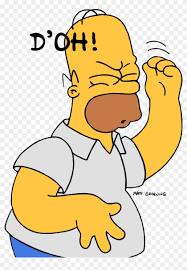

This did end up meaning that the solution is a bit more... verbose than it would otherwise be. I find myself approaching things more formally so that I would avoid simple bugs.

Yikes.

Am I happy with the run time? No.

Do I want to spend any more of my life thinking about pruning DFS branches? Also No.

In [73]:
%%time

ORE = 0
CLAY = 1
OBSIDIAN = 2
GEODE = 3

Resource = Literal[0, 1, 2, 3]


class State(NamedTuple):
    ORE: int
    CLAY: int
    OBSIDIAN: int
    GEODE: int

    def __add__(self, other):
        return State(
            self.ORE + other.ORE,
            self.CLAY + other.CLAY,
            self.OBSIDIAN + other.OBSIDIAN,
            self.GEODE + other.GEODE,
        )

    def __sub__(self, other):
        return State(
            self.ORE - other.ORE,
            self.CLAY - other.CLAY,
            self.OBSIDIAN - other.OBSIDIAN,
            self.GEODE - other.GEODE,
        )

    def __mul__(self, num: int):
        return State(
            self.ORE * num,
            self.CLAY * num,
            self.OBSIDIAN * num,
            self.GEODE * num,
        )


Blueprint = Dict[Resource, State]


def parse_line(line: str) -> Blueprint:
    ore_counts = list(map(int, re.findall(r"\d+", line)))
    return {
        ORE: State(ore_counts[1], 0, 0, 0),
        CLAY: State(ore_counts[2], 0, 0, 0),
        OBSIDIAN: State(ore_counts[3], ore_counts[4], 0, 0),
        GEODE: State(ore_counts[5], 0, ore_counts[6], 0),
    }


def possible_geodes(blueprint: Blueprint, robots: State, resouces: State, budget: int):
    # given the current number of robots and resources, if we ignore costs,
    # what's the absolute maximum number of geodes we could get?
    new_robots = robots
    new_resources = resouces

    for _ in range(budget):
        for resource, recipe in blueprint.items():
            amounts = new_resources - recipe

            is_possible = all(a >= 0 for a in amounts)
            if not is_possible:
                continue

            new_robots = list(new_robots)
            new_robots[resource] += 1
            new_robots = State(*new_robots)

        new_resources += new_robots

    return new_resources.GEODE


def maximise_geodes(
    blueprint: Blueprint,
    initial_robots: State,
    initial_resources: State,
    initial_budget: int,
):
    # there's no point creating more bots when they can produce everything we
    # might need in a single turn
    useful_robots: Dict[Resource, int] = {
        ORE: max(v.ORE for v in blueprint.values()),
        CLAY: max(v.CLAY for v in blueprint.values()),
        OBSIDIAN: max(v.OBSIDIAN for v in blueprint.values()),
        GEODE: 100000000,
    }

    best = 0
    stack = [(initial_robots, initial_resources, initial_budget)]

    while stack:
        robots, resources, budget = stack.pop()

        if best >= possible_geodes(blueprint, robots, resources, budget):
            # no point exploring this branch, there's no way it can give us more
            # geodes
            continue

        current_final_amount = robots.GEODE * budget + resources.GEODE
        best = max(best, current_final_amount)

        for robot, recipe in blueprint.items():
            if robots[robot] >= useful_robots[robot]:
                # already have as many as we could possibly need, skip it
                continue

            # otherwise, gather the time it'll take to produce the resources
            # for this specific robot, and add that onto the stack
            missing_robots_needed = any(
                robots[resource] == 0
                for (resource, cost) in enumerate(recipe)
                if cost > 0
            )

            if missing_robots_needed:
                # don't yet have the robots producing resources required, so
                # ignore it for now
                continue

            # +ve if we're missing some resources
            missing_amounts = recipe - resources
            # how long do we need for the resources to be available?
            cycles_per_resource = list(
                ceil(missing_amounts[resource] / robots[resource])
                for resource, _ in enumerate(recipe)
                if missing_amounts[resource] > 0
            )

            cycles_required = max([0] + cycles_per_resource)

            if cycles_required < budget:
                # we have time to gather the resources, gogogogo
                new_robots = list(robots)
                new_robots[robot] += 1
                new_robots = State(*new_robots)

                # we need N cycles to produce the resources, then one more to
                # create the bot
                delta = cycles_required + 1
                new_resources = resources + robots * delta - recipe
                stack.append((new_robots, new_resources, budget - delta))

    return best


def sum_blueprint_quality(blueprints: List[Blueprint], budget: int = 24):
    total = 0
    for blueprint_id, blueprint in enumerate(blueprints, 1):
        best = maximise_geodes(
            blueprint,
            State(1, 0, 0, 0),
            State(0, 0, 0, 0),
            budget,
        )
        total += blueprint_id * best

    return total


data = Input(19, parse_line)
sum_blueprint_quality(data)

CPU times: user 5.94 s, sys: 26.9 ms, total: 5.97 s
Wall time: 5.97 s


960

In [74]:
assert _ == 960, "Day 19.1"

In [75]:
%%time

def multiply_geods(blueprints: List[Blueprint], budget: int = 32):
    total = 1
    for blueprint in blueprints:
        total *= maximise_geodes(
            blueprint,
            State(1, 0, 0, 0),
            State(0, 0, 0, 0),
            budget,
        )

    return total

multiply_geods(data[:3], 32)

CPU times: user 52.6 s, sys: 236 ms, total: 52.8 s
Wall time: 52.9 s


2040

In [76]:
assert _ == 2040

## [Day 20: Grove Positioning System](https://adventofcode.com/2022/day/20)

Python's double ended queue, the deque, makes this problem quite simple which is nice. The trick was needing to process the numbers _in their original order_, BUT there's a sneaky part of the input data in that there are duplicate numbers. As such we create a deque of the number and their original position in the data using enumerate.

In [77]:
from collections import deque


def mix_data(data: List[int], mixed: Deque[Tuple[int, int]]):
    for idx, num in enumerate(data):
        index = mixed.index((idx, num))
        mixed.rotate(-index)

        mixed.popleft()

        mixed.rotate(-num)
        mixed.appendleft((idx, num))

    return list(n for _, n in mixed)


def find_coordinates(data: List[int]):
    mixed = mix_data(data, deque(enumerate(data)))
    zeroth_index = mixed.index(0)
    coords = [
        mixed[(zeroth_index + offset) % len(data)] for offset in [1000, 2000, 3000]
    ]
    return sum(coords)


data = Input(20, int)
find_coordinates(data)

988

In [78]:
assert _ == 988, "Day 20.1"

In [79]:
def find_coordinates_again(data: List[int]):
    key = 811589153
    origial_zeroth_index = data.index(0)
    actual_data = [d * key for d in data]

    mixing_data = deque(enumerate(actual_data))
    for _ in range(10):
        mixed = mix_data(actual_data, mixing_data)

    zeroth_index = mixing_data.index((origial_zeroth_index, 0))

    coords = [
        mixed[(zeroth_index + offset) % len(data)] for offset in [1000, 2000, 3000]
    ]
    return sum(coords)

find_coordinates_again(data)

7768531372516

In [80]:
assert _ == 7768531372516, "Day 20.2"

## [Day 21: Monkey Math](https://adventofcode.com/2022/day/21)

I really enjoyed this problem! I think there's many ways of solving it, but the first one that came to my mind was to materialize the entire tree and walk it in postorder so all children are resovled before evaluating the current one.

In [81]:
class IntNode(NamedTuple):
    value: int


class ExpressionNode(NamedTuple):
    operation: Callable[[int, int], int]
    left: str
    right: str


Node = Union[IntNode, ExpressionNode]
Tree = Dict[str, Node]


def parse_lines(lines: List[str]):
    tree: Tree = {}
    ops = {
        "+": operator.add,
        "-": operator.sub,
        "*": operator.mul,
        "/": operator.floordiv,
        "=": operator.eq,
    }
    for line in lines:
        name, _, *chunks = re.split("[:\\s]", line.strip())
        if len(chunks) == 1:
            tree[name] = IntNode(int(chunks[0]))
        else:
            tree[name] = ExpressionNode(ops[chunks[1]], chunks[0], chunks[2])

    return tree


def evaluate_node(tree: Tree, name: str = "root") -> int:
    node = tree[name]
    if isinstance(node, IntNode):
        return node.value

    left_value = evaluate_node(tree, node.left)
    right_value = evaluate_node(tree, node.right)
    return node.operation(left_value, right_value)


data = Input(21, parse_lines, whole_file=True)
evaluate_node(data)

282285213953670

In [82]:
assert _ == 282285213953670, "Day 21.1"

For the second part we're looking to change a value that the human ("hmn") node shouts such that the root node is equal. I first just incremented it by 1 and output the answer to see what it was doing.. maybe there was a pattern similar to day 16 I jump forward to? Instead what I noticed was that the operation the root node was doing was an addition of two values.. but if they needed to be equal, then if I changed that to be a subtraction operation, I could just look for where the result _changed sign_.

With that in mind, I could write a cheeky binary search and find it in no time!

In [83]:
def root_matches(tree: Tree):
    # replace the operator with a sub operation so we can see when we flip sign
    root = tree["root"]
    assert isinstance(root, ExpressionNode)
    tree["root"] = ExpressionNode(operator.sub, root.left, root.right)

    lower = 0
    upper = 10

    tree["humn"] = IntNode(0)
    initial_value = evaluate_node(tree)

    # first search for an upper bound at which we flip sign
    while True:
        tree["humn"] = IntNode(upper)
        if evaluate_node(tree) * initial_value < 0:
            break
        upper *= 10

    # now binary search to find the result
    print(
        "Pivot".rjust(17),
        "Lower".rjust(17),
        "Upper".rjust(17),
        "Result".rjust(17),
    )

    while True:
        i = (lower + upper) // 2
        tree["humn"] = IntNode(i)

        result = evaluate_node(tree)

        print(
            str(i).rjust(17),
            str(lower).rjust(17),
            str(upper).rjust(17),
            str(result).rjust(17),
        )

        if result == 0:
            break

        # split on if we pass the pivot point, one side is pos+ other is neg-
        if result * initial_value < 0:
            upper = i - 1
        else:
            lower = i

    # the result may not be FIRST one that gives zero, so jump back a bit and
    # go forward to find it
    for n in range(i - 10, i):
        tree["humn"] = IntNode(n)
        result = evaluate_node(tree)
        if result == 0:
            return n


root_matches(data)

            Pivot             Lower             Upper            Result
    5000000000000                 0    10000000000000   -36979332023043
    2499999999999                 0     4999999999999    34131779088120
    3749999999999     2499999999999     4999999999999    -1423776467457
    3124999999998     2499999999999     3749999999998    16354001310390
    3437499999998     3124999999998     3749999999998     7465112421471
    3593749999998     3437499999998     3749999999998     3020667977052
    3671874999998     3593749999998     3749999999998      798445754802
    3710937499998     3671874999998     3749999999998     -312665356296
    3691406249997     3671874999998     3710937499997      242890199289
    3701171874997     3691406249997     3710937499997      -34887578535
    3696289062496     3691406249997     3701171874996      104001310386
    3698730468746     3696289062496     3701171874996       34556865975
    3699951171871     3698730468746     3701171874996        -16

3699945358564

In [84]:
assert _ == 3699945358564

## [Day 22](https://adventofcode.com/2022/day/22)

So the first part for this wasn't too bad. When there's a direction and a heading I instinctively reach for representing the data as complex numbers. The realationship of real and imaginary components make rotates very easy to model.

<div>
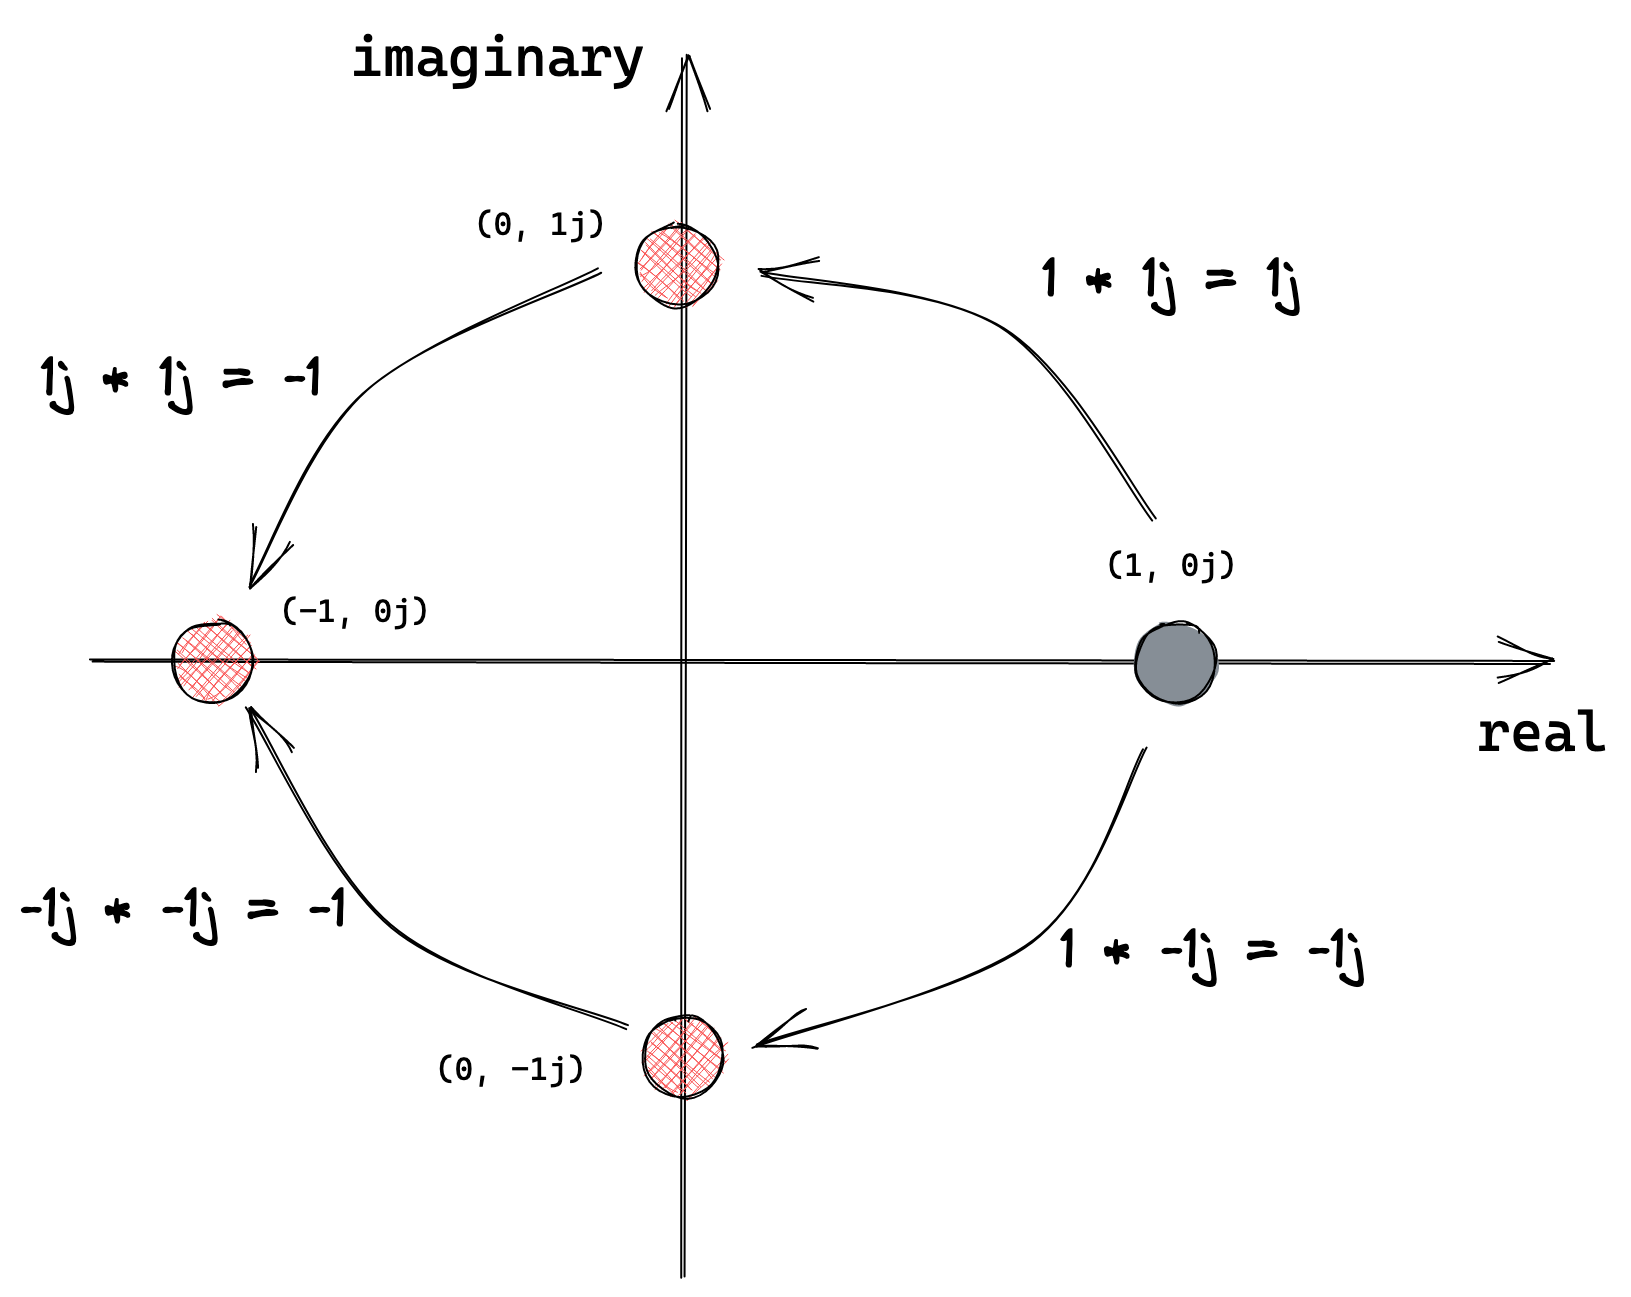
</div>

In [85]:
def parse_lines(lines: List[str]):
    lines = list(lines)

    *grid_lines, _, instructions_str = lines

    grid = {
        (x + y * 1j): char
        for y, line in enumerate(grid_lines, 0)
        for x, char in enumerate(line, 0)
        if char in "#."
    }

    return grid, instructions_str.strip()


# down is 1j just because that's how we read the data.
DOWN = 1j
RIGHT = 1
UP = -1j
LEFT = -1


def wrap_2d(loc: complex, direction: complex):
    x, y = loc.real, loc.imag

    match direction, x // 50, y // 50:
        # UP
        case -1j, 0, _:
            return complex(x, 199), direction
        case -1j, 1, _:
            return complex(x, 149), direction
        case -1j, 2, _:
            return complex(x, 49), direction
        # DOWN
        case 1j, 0, _:
            return complex(x, 100), direction
        case 1j, 1, _:
            return complex(x, 0), direction
        case 1j, 2, _:
            return complex(x, 0), direction
        # RIGHT
        case 1, _, 0:
            return complex(50, y), direction
        case 1, _, 1:
            return complex(50, y), direction
        case 1, _, 2:
            return complex(0, y), direction
        case 1, _, 3:
            return complex(0, y), direction
        # LEFT
        case -1, _, 0:
            return complex(149, y), direction
        case -1, _, 1:
            return complex(99, y), direction
        case -1, _, 2:
            return complex(99, y), direction
        case -1, _, 3:
            return complex(49, y), direction


def follow_instructions(
    grid: Dict[complex, str],
    instructions: str,
    wrap: Callable[[complex, complex], Tuple[complex, complex]],
):
    direction = 1
    loc = 50

    for instr in re.findall(r"\d+|[RL]", instructions):
        match instr:
            case "R":
                direction *= 1j
            case "L":
                direction *= -1j
            case _:
                for _ in range(int(instr)):
                    next_coord = loc + direction

                    if next_coord not in grid:
                        next_coord, direction = wrap(next_coord, direction)

                    if grid[next_coord] == "#":
                        break

                    loc = next_coord

    row = int(loc.imag) + 1
    col = int(loc.real) + 1

    return (1000 * row) + (4 * col) + [RIGHT, DOWN, LEFT, UP].index(direction)


grid, instructions = Input(22, parse_lines, whole_file=True)
follow_instructions(grid, instructions, wrap_2d)

73346

In [86]:
assert _ == 73346

Wrapping a cube... oh god.

I cut my map out of paper to make sure I was doing it the right way, what a mess. But the idea of solving the generic case made me feel a bit sick, so I plugged away at a static one instead.

Hey it works..


<div>
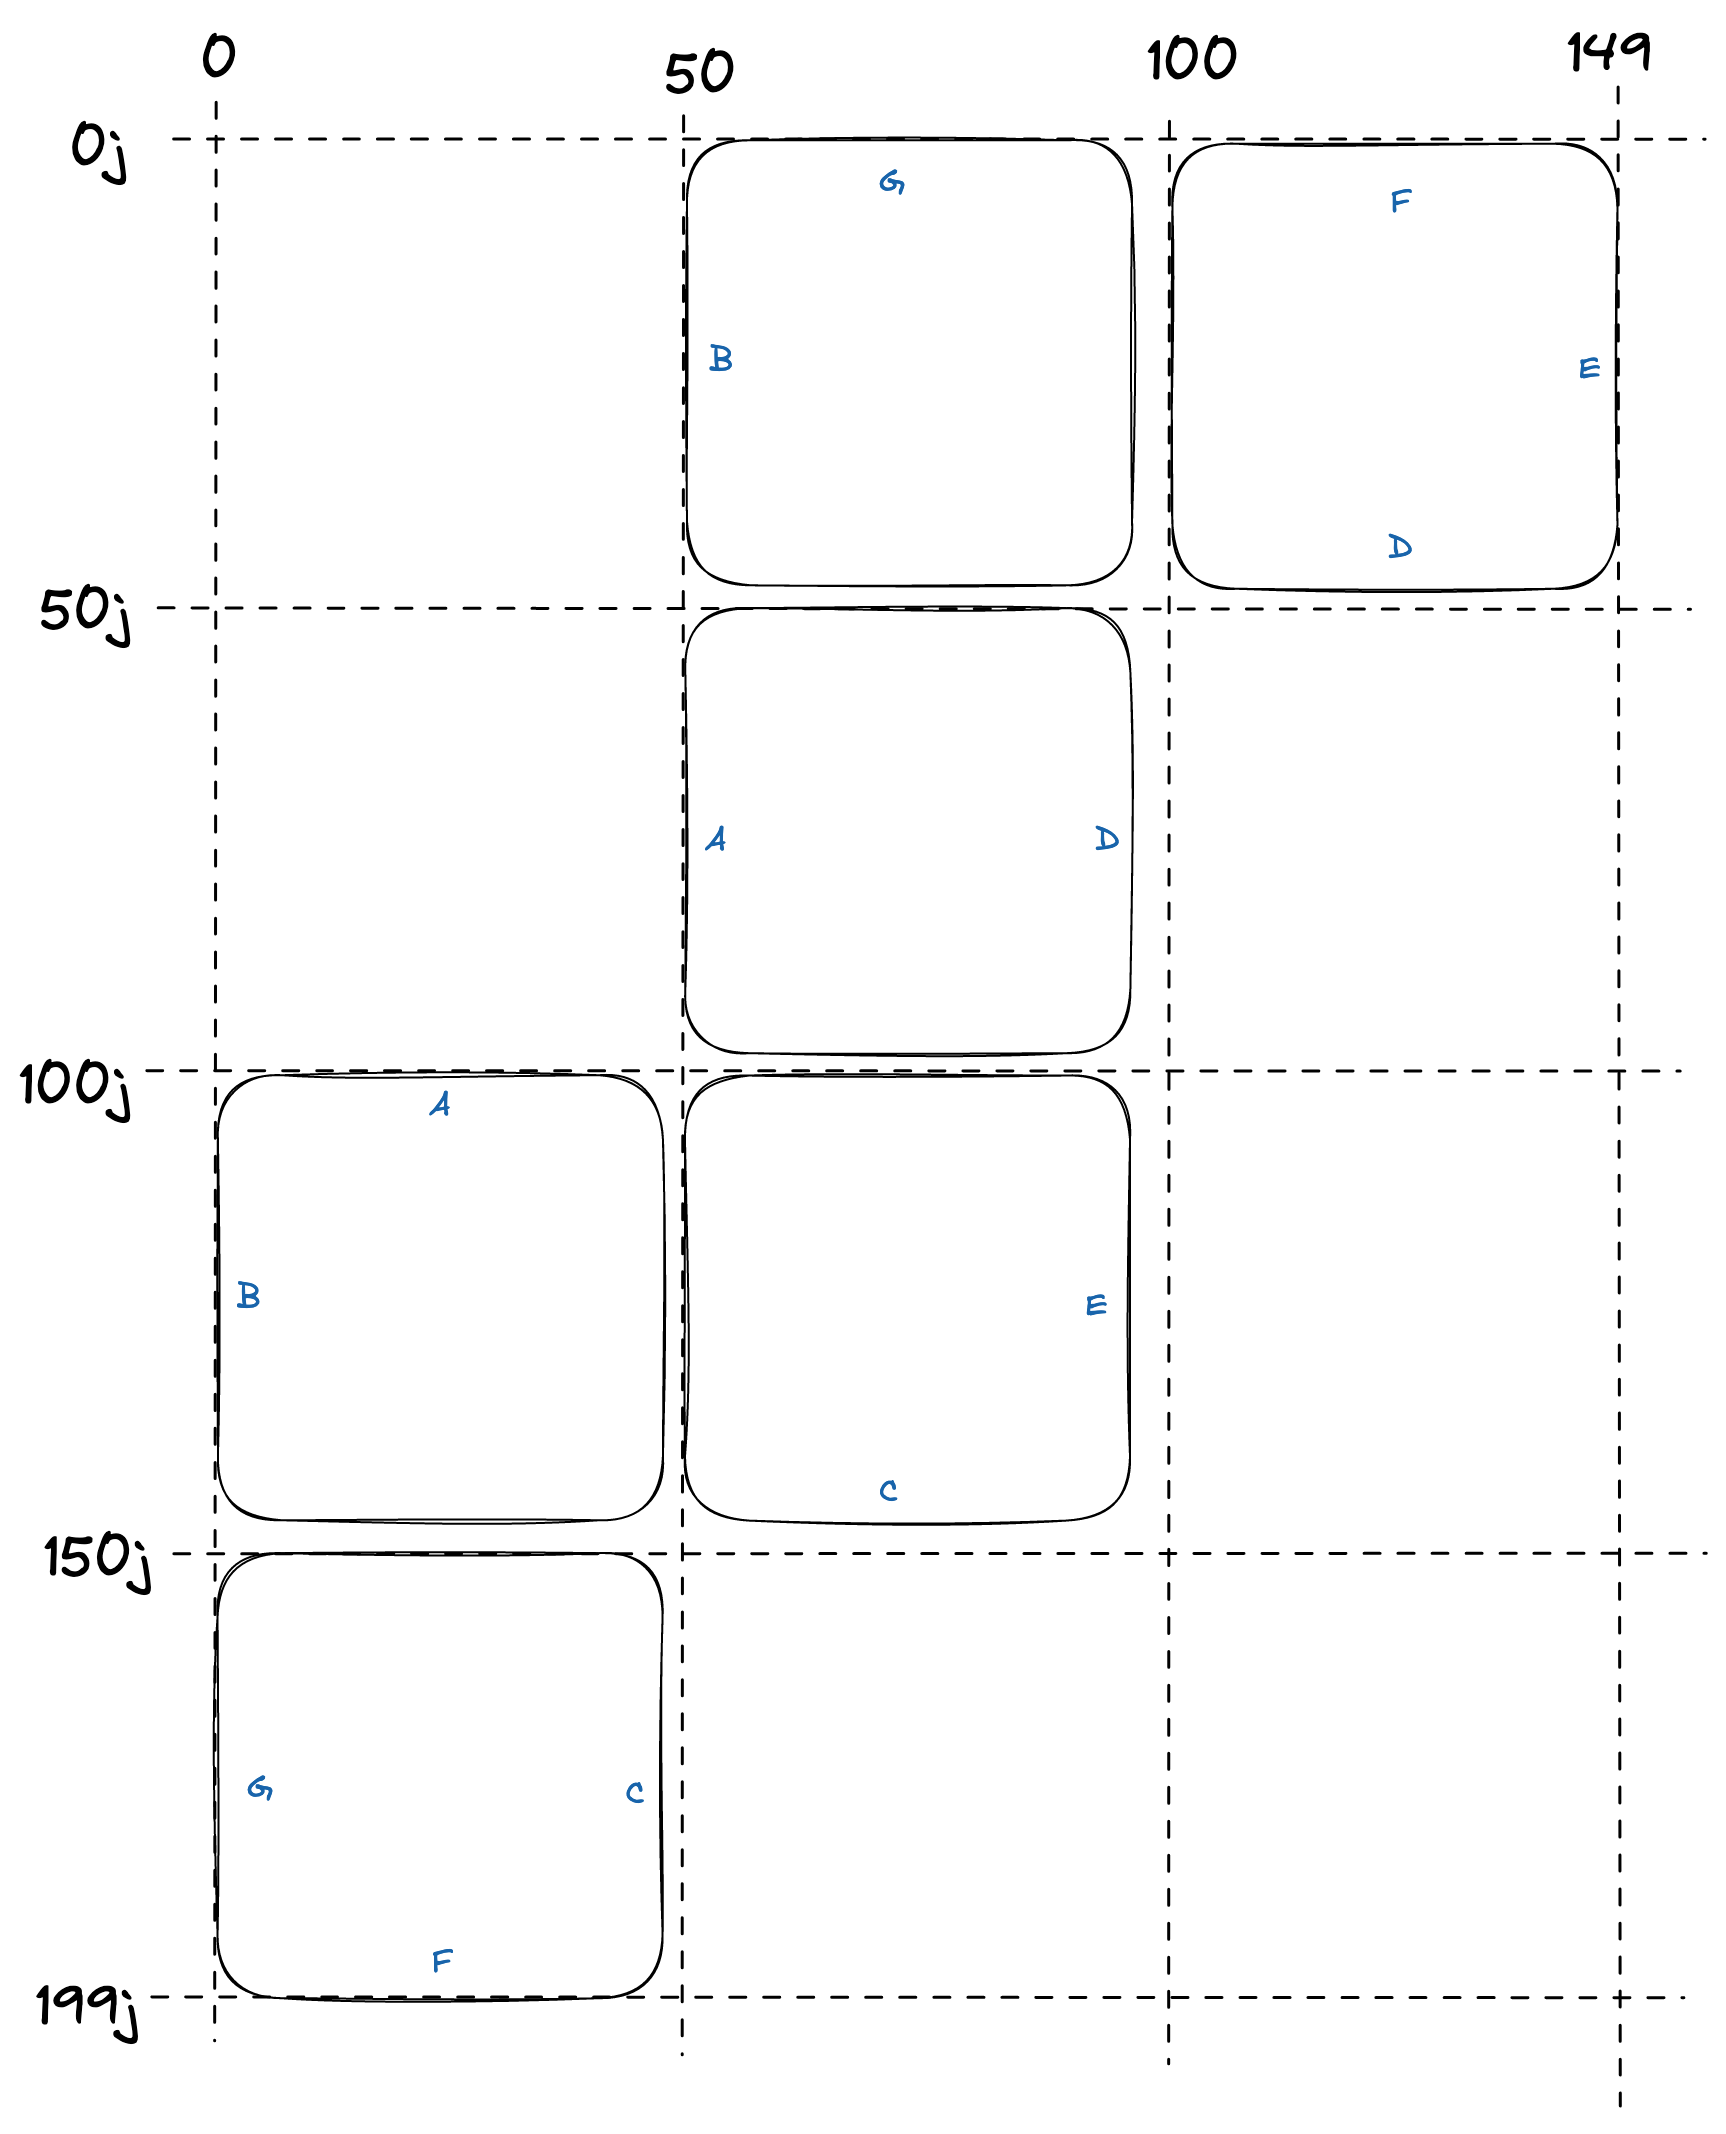
</div>

In [87]:
def wrap_cube(loc: complex, direction: complex):
    x, y = loc.real, loc.imag
    
    # I figured these out manually for my own input... it is NOT
    # a generic solution
    match direction, x // 50, y // 50:
        # UP
        case -1j, 0, _:
            return complex(50, 50 + x), RIGHT  # edge: A
        case -1j, 1, _:
            return complex(0, 150 + (x - 50)), RIGHT  # edge: G
        case -1j, 2, _:
            return complex(x - 100, 199), UP  # edge: F
        # DOWN
        case 1j, 0, _:
            return complex(100 + x, 0), DOWN  # edge: F
        case 1j, 1, _:
            return complex(49, 150 + (x - 50)), LEFT  # edge: C
        case 1j, 2, _:
            return complex(99, 50 + (x - 100)), LEFT  # edge: D
        # RIGHT
        case 1, _, 0:
            return complex(99, 100 + (49 - y)), LEFT  # edge: E
        case 1, _, 1:
            return complex(100 + (y - 50), 49), UP  # edge: D
        case 1, _, 2:
            return complex(149, 50 - (y - 100)), LEFT  # edge E
        case 1, _, 3:
            return complex(50 + (y - 150), 149), UP  # edge C
        # LEFT
        case -1, _, 0:
            return complex(50, 100 + (49 - y)), RIGHT  # edge B
        case -1, _, 1:
            return complex(y - 50, 100), DOWN  # edge A
        case -1, _, 2:
            return complex(50, 149 - y), RIGHT  # edge B
        case -1, _, 3:
            return complex(50 + y - 150, 0), DOWN  # edge G
        
follow_instructions(grid, instructions, wrap_cube)

106392

In [88]:
assert _ == 106392

## [Day 23: Unstable Diffusion](https://adventofcode.com/2022/day/23)

So this one wasn't too bad, I think I dodged a bullet by making use of python's generators to exit eaerly where we can so we don't end up generating too many states to check. Again I used complex numbers to represent the x,y coordinates as comparisions / mutations of them are really quick. Than an using sets for membership tests means it all evaluates pretty quickly!

In [89]:
def parse_input(lines: List[str]):
    return [
        complex(x, y)
        for y, line in enumerate(list(lines))
        for x, char in enumerate(line)
        if char == "#"
    ]


def propose_step(elf: complex, heading: complex):
    match heading:
        case -1j:  # NORTH
            deltas = [-1j, 1 - 1j, -1 - 1j]
        case 1j:  # SOUTH
            deltas = [1j, 1 + 1j, -1 + 1j]
        case -1:  # WEST
            deltas = [-1, -1 - 1j, -1 + 1j]
        case 1:  # EAST
            deltas = [1, 1 - 1j, 1 + 1j]

    for delta in deltas:
        yield elf + delta


def all_neighbours(elf: complex):
    deltas = (-1j, 1 - 1j, 1, 1 + 1j, 1j, -1 + 1j, -1, -1 - 1j)
    for delta in deltas:
        yield elf + delta


def cycle(elves: List[complex]):
    # complex numbers for North, South, West, East
    directions = deque([-1j, 1j, -1, 1])
    made_change = True

    while made_change:
        made_change = False
        next_elves: List[complex] = elves[:]
        elf_locations = set(elves)

        # PHASE 1: Propose moves
        for elf_num, elf in enumerate(elves):
            has_neighbour = any(
                neighbour in elf_locations for neighbour in all_neighbours(elf)
            )
            if not has_neighbour:
                continue

            made_change = True

            for direction in directions:
                for proposed in propose_step(elf, direction):
                    if proposed in elf_locations:
                        break
                else:
                    # for loop exited cleanly, so no location is occupied
                    next_elves[elf_num] = elf + direction
                    break

        # PHASE 2: Move
        counts = Counter(next_elves)
        for elf_num, elf in enumerate(next_elves):
            if counts[elf] == 1:
                elves[elf_num] = elf

        directions.rotate(-1)

        # we made a change, suspend
        yield elves


def find_area(elves: List[complex]):
    state_iter = cycle(elves)
    for _ in range(10):
        next(state_iter)

    width = max(p.real for p in elves) - min(p.real for p in elves) + 1
    height = max(p.imag for p in elves) - min(p.imag for p in elves) + 1
    area = width * height
    return int(area) - len(elves)


data = Input(23, parse_input, whole_file=True)
find_area(data[:])

4254

In [90]:
assert _ == 4254

In [91]:
%%time

def count_rounds_until_stop(elves: List[complex]):
    num_rounds = 0

    for _ in cycle(elves):
        num_rounds += 1

    return num_rounds


count_rounds_until_stop(data[:])

CPU times: user 3.8 s, sys: 18.4 ms, total: 3.82 s
Wall time: 3.83 s


992

In [92]:
assert _ == 992

## [Day 24: Blizzard Basin](https://adventofcode.com/2022/day/24)

Another breath first search! As there's no real way of understanding how far we are from the destination as the paths we can take change with each tick, we simply keep track of every possible state at a given time. As soon as we see our goal, we're done!

This did require me changing the input every so slightly to make the parsing easier, by adding an "E" (entrance) and "D" (destination) to the input.

Doign some reading after I saw that people noticed the blizzards would move in a repeated pattern, and as such we'd need to only track the LCM of the width and height, after which we'd see them all again. This would mean there'd be a large number of paths we could discard, as once we've seen one point at a given step in the cycle, we can ignore all future ones. As this retruns quite quickly though, I didn't see the point in making any changes.

I did this puzzle in a burst with others... you can tell by the over use of complex numbers but it does make operations simpler!

In [93]:
%%time

Blizzard = Tuple[complex, complex]


def move_blizzards(blizzards: List[Blizzard], width: int, height: int):
    new_blizzards = []
    for pos, heading in blizzards:
        new_pos = pos + heading
        if new_pos.real == 0:
            new_pos = complex(width - 2, new_pos.imag)

        if new_pos.real == width - 1:
            new_pos = complex(1, new_pos.imag)

        if new_pos.imag == 0:
            new_pos = complex(new_pos.real, height - 2)

        if new_pos.imag == height - 1:
            new_pos = complex(new_pos.real, 1)

        new_blizzards.append((new_pos, heading))
    return new_blizzards


def get_neighbours(point: complex):
    yield point
    for direction in [-1j, 1, 1j, -1]:
        yield point + direction
        

def find_shortest_path(grid: List[str], part_two=False):
    allowed = set()
    blizzards = []
    headings = {"^": -1j, ">": 1, "v": 1j, "<": -1}
    entrance = None
    destination = None

    for y, line in enumerate(grid):
        for x, char in enumerate(line.strip()):
            point = complex(x, y)

            if char in "^>v<.ED":
                allowed.add(point)
            if char in "^>v<":
                blizzards.append((point, headings[char]))
            if char == "E":
                entrance = point
            if char == "D":
                destination = point

    possible_states = {entrance}
    width = len(grid[0])
    height = len(grid)

    phase = 0
    minute = 1
    while True:
        blizzards = move_blizzards(blizzards, width, height)

        invalid = set(pos for pos, _ in blizzards)
        next_states = set()

        for state in possible_states:
            for neighbour in get_neighbours(state):
                if neighbour in allowed and neighbour not in invalid:
                    next_states.add(neighbour)

        if phase == 0 and destination in next_states:                            
            if not part_two:
                break
            
            # start at the end, now go back to the start
            next_states = {destination}
            phase = 1

        if phase == 1 and entrance in next_states:
            # start from the beginning, head towards the end
            next_states = {entrance}
            phase = 2

        if phase == 2 and destination in next_states:
            # done!
            break

        possible_states = next_states
        minute += 1
    else:
        print("no destination reached")
        
    return minute

        
        
data = Input(24)
find_shortest_path(data)

CPU times: user 346 ms, sys: 2.12 ms, total: 348 ms
Wall time: 348 ms


249

In [94]:
assert _ == 249, "Day 24.1"

In [95]:
find_shortest_path(data, True)

735

In [96]:
assert _ == 735, "Day 24.2"

## [Day 25: Full of Hot Air](https://adventofcode.com/2022/day/25)

It took me a bit of time to get my head around how this problem dealt with the shifting down of two values. Any time a problem can be broken down to a smaller version of itself I often reach for recursion, but you needn't in this case at all. 

In [97]:
def snafu_to_decimal(val: str):
    if not val:
        return 0
    *a, b = val
    return snafu_to_decimal(a) * 5 + "=-012".find(b) - 2


def decimal_to_snafu(val: int):
    if val == 0:
        return ""
    a, b = divmod(val + 2, 5)
    return decimal_to_snafu(a) + "=-012"[b]


decimal_to_snafu(sum(snafu_to_decimal(v) for v in Input(25)))

'2-0-020-1==1021=--01'

And that's a wrap! I really struggled with this year, I think my head just wasn't in the game. Several days I just didn't get anywhere, others I simply misread the problem. I'm glad it's over, the sense of relief was palpable. I'm sure I'll have forgotten all of the pain by next year thought! :D


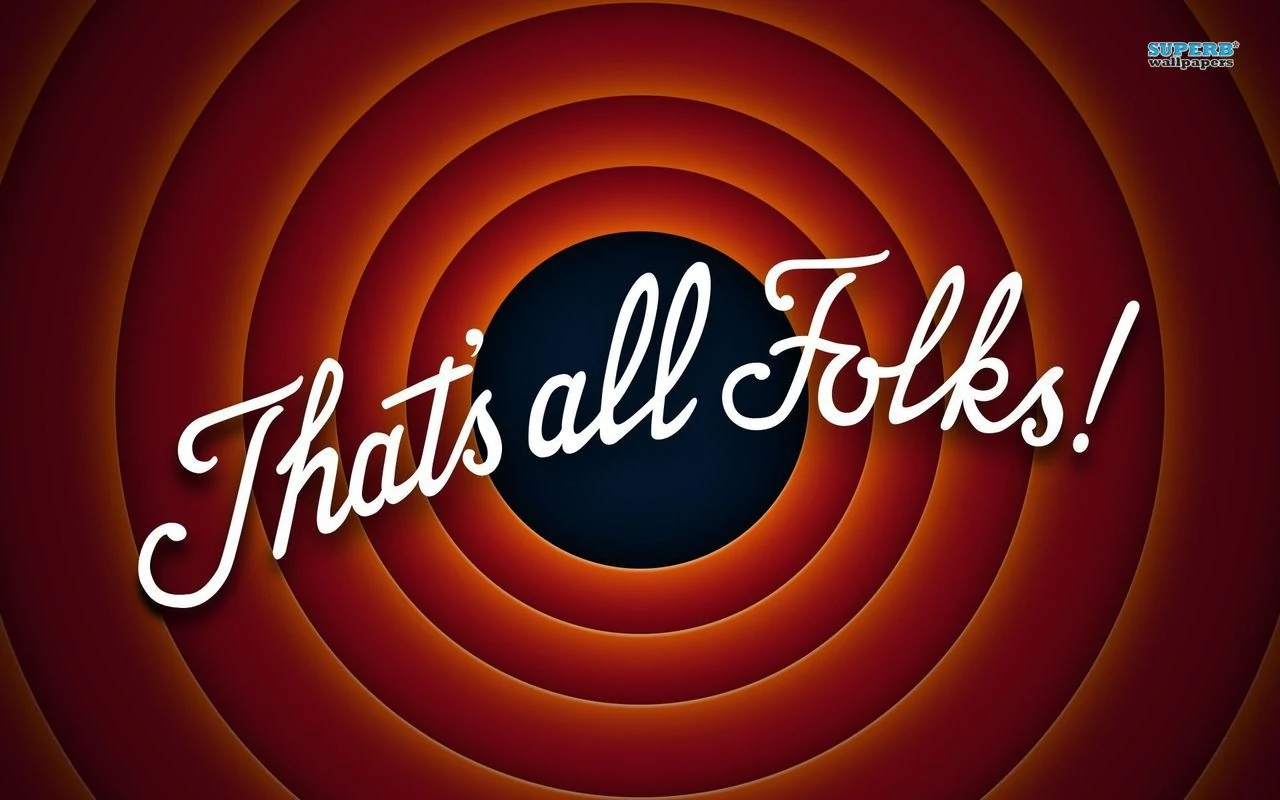